# Collision Detection Notebook
Implementation of 3D Collision Detection Algorithms

********************************************************************************************

In [1]:
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import numba
import pyvista as pv

In [2]:
from primitives.triangle import Triangle
from scenes.scene import Scene
from scenes.render import render_scene
from utils.misc import get_floor

/Users/dipanjan/anaconda3/envs/Primitive-Intersection/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


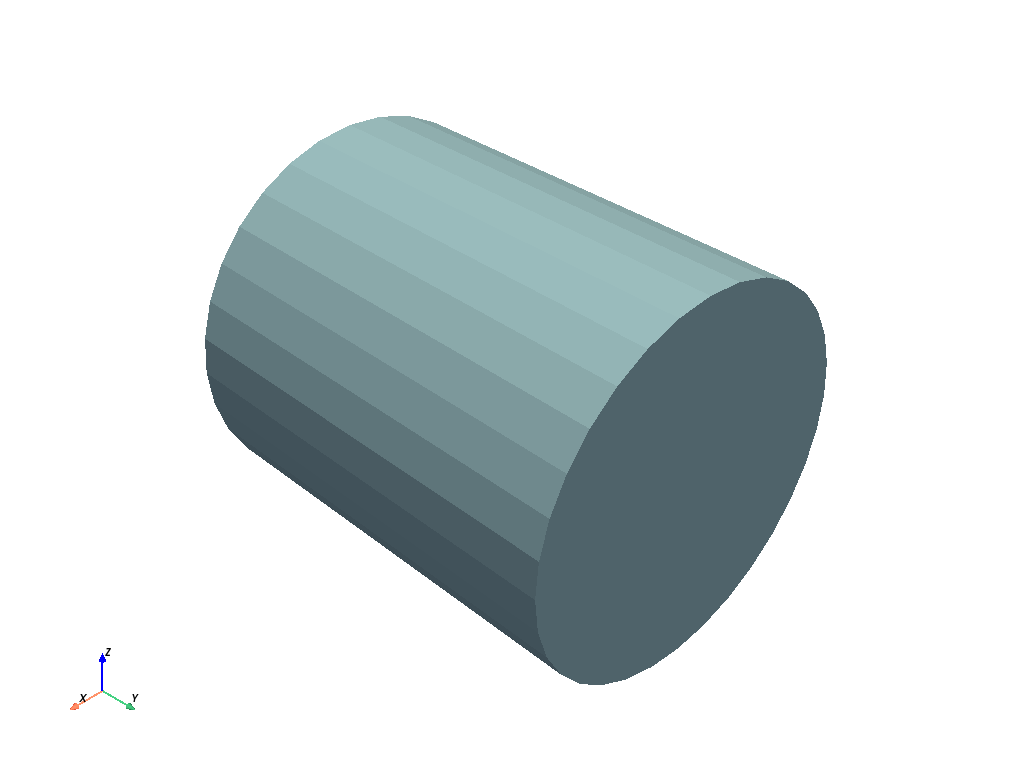

In [3]:
#load object

sphere_path = "objects/sphere.obj"
cube_path = "objects/cube.obj"
cylinder_path = "objects/cylinder.obj"
rabbit = "objects/rabbit.obj"
carrot = "objects/carrot.obj"
plane = "objects/plane.obj"
squirrel = "objects/squirrel.obj"
tree = "objects/broad_deciduous_tree_green_leaves.obj"
ant = "objects/ant.obj"
fireball = "objects/fireball.obj"
dragon = "objects/dragon.obj"
crawler = "objects/crawler.obj"


file_path = cylinder_path

path = Path(file_path).resolve()
mesh = pv.read(path)
mesh.plot()


In [4]:
# # Example: 15k primitives - helmet object
#
#
# from pyvista import examples
#
# helmet_file = examples.gltf.download_damaged_helmet()
# texture = examples.download_dikhololo_night()
#
# pl = pv.Plotter()
# pl.import_gltf(helmet_file)
# pl.set_environment_texture(texture)
# pl.camera.zoom(1.7)
# pl.show()

In [5]:
# block = pv.read(helmet_file)
# mesh = block[0][0][0]
# mesh.plot(color='lightblue', show_edges=True, cpos='xy')

In [6]:
mesh = mesh.triangulate()
points = np.ascontiguousarray(mesh.points)
points

array([[ 1.50000000e+00,  2.30000019e+00, -1.50000012e+00],
       [ 1.49999690e+00, -2.50000000e+00, -1.50000298e+00],
       [ 1.17853868e+00, -2.50000000e+00, -1.76381588e+00],
       [ 1.17854238e+00,  2.30000019e+00, -1.76381350e+00],
       [ 1.17854238e+00,  2.30000019e+00, -1.76381350e+00],
       [ 1.17853868e+00, -2.50000000e+00, -1.76381588e+00],
       [ 8.11789870e-01, -2.50000000e+00, -1.95984614e+00],
       [ 8.11794221e-01,  2.30000019e+00, -1.95984435e+00],
       [ 8.11794221e-01,  2.30000019e+00, -1.95984435e+00],
       [ 8.11789870e-01, -2.50000000e+00, -1.95984614e+00],
       [ 4.13844347e-01, -2.50000000e+00, -2.08056068e+00],
       [ 4.13849145e-01,  2.30000019e+00, -2.08055973e+00],
       [ 4.13849145e-01,  2.30000019e+00, -2.08055973e+00],
       [ 4.13844347e-01, -2.50000000e+00, -2.08056068e+00],
       [-4.96024131e-06, -2.50000000e+00, -2.12132025e+00],
       [ 1.72336712e-07,  2.30000019e+00, -2.12132025e+00],
       [ 1.72336712e-07,  2.30000019e+00

In [7]:
points = np.ascontiguousarray(mesh.points)
faces = mesh.faces.reshape((-1,4))[:, 1:4]
vertices = np.ascontiguousarray(points[faces], dtype=np.float64)

In [8]:
# Initialise an empty list for primitives
objects = numba.typed.List()

In [9]:
from utils.vectors import normalize

# Calculate the bounding box of the point cloud
centroid = mesh.center

min_p = np.min(vertices)-5

centroid, min_p

([0.0, -0.09999990463256836, 0.0], -7.5)

In [10]:
# Add the triangles in the list of objects
for v in vertices:
    a,b,c = v[0], v[1], v[2]

    triangle = Triangle(vertex_1=np.ascontiguousarray(a, dtype=np.float64),
                                   vertex_2=np.ascontiguousarray(b, dtype=np.float64),
                                   vertex_3=np.ascontiguousarray(c, dtype=np.float64))
    objects.append(triangle)

len(objects)

128

In [11]:
min_p

-7.5

In [12]:
# Define the camera parameters based on the bounding box
camera = centroid + np.array([0.0, 0.0, min_p])  # Position behind the centroid
look_at = normalize(centroid - camera)  # Looking towards the centroid
camera, look_at

(array([ 0.       , -0.0999999, -7.5      ]), array([0., 0., 1.]))

In [13]:
# Setup scene

# screen
width=300
height=300


# Initialise the scene with lights and camera
scene = Scene(look_at=look_at, camera=camera, width=width, height=height)

In [14]:
from accelerators.bvh import BoundedBox

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
bounded_boxes = numba.typed.List()
for i in range(len(objects)):
    bounded_boxes.append(BoundedBox(objects[i], i))

len(objects), len(bounded_boxes)

(128, 128)

In [15]:
bounded_boxes[3].bounds.centroid

array([ 0.9951683 , -0.0999999 , -1.86182892])

In [16]:
from accelerators.bvh_iterative import build_bvh

# Initialise a bounding volume hierarchy tree
start = 0
end = len(bounded_boxes)

ordered_prims = numba.typed.List()
ordered_prims.append(objects[0]) # just for numba
ordered_prims.pop(0)

total_nodes = numba.typed.List()
total_nodes.append(0)

split_method = 0 # 0: surface area heuristics, 1: mid-point, 2: equal parts

start_t = time.time()
root = build_bvh(objects, bounded_boxes, start, end, ordered_prims, total_nodes, split_method)
# root = build_bvh_iterative(objects, bounded_boxes)

end_t = time.time()
print("Elapsed (with compilation) = %s" % (end_t - start_t))

[ 6.55651093e-07 -9.99999046e-02  2.38418579e-07] 1 64
[-0.38083452 -0.0999999  -0.38083407] 2 16
[ 0.36322301 -0.0999999  -1.86642364] 0 6
[ 1.16721773 -0.0999999  -1.74686891] 0 2
[ 1.16721773 -0.0999999  -1.74686891] 0 2
[ 0.99516629 -0.0999999  -1.86182997] 0 3
[-1.74343586e-06 -9.99999046e-02 -2.06057081e+00] 0 8
[ 0.6128194  -0.0999999  -2.02020273] 0 5
[-0.20295026 -0.0999999  -2.06057081] 0 9
[-0.20295026 -0.0999999  -2.06057057] 0 9
[-0.40987474 -0.0999999  -2.06057057] 0 10
[-0.40987711 -0.0999999  -2.06057039] 0 10
[-0.61282322 -0.0999999  -2.02020165] 0 11
[-1.54805411 -0.0999999  -0.26127836] 2 22
[-1.31353773 -0.0999999  -1.60054973] 0 15
[-1.31353916 -0.0999999  -1.60054904] 0 15
[-1.4855893  -0.0999999  -1.48558855] 0 16
[-1.48559013 -0.0999999  -1.48558795] 2 16
[-1.63190708 -0.0999999  -1.33927071] 0 17
[-1.86642298 -0.0999999   0.17205204] 2 25
[-1.98138452 -0.0999999  -0.60104603] 2 21
[-1.98138452 -0.0999999  -0.60104603] 2 21
[-2.06057104 -0.0999999  -0.40987302] 

In [17]:
total_nodes[0]

255

In [18]:
from accelerators.bvh import LinearBVHNode

# create a linear representation of the bvh tree (empty)

start_t = time.time()
linear_bvh = numba.typed.List()
for _ in range(total_nodes[0]):
    linear_bvh.append(LinearBVHNode())

end_t = time.time()
print("Elapsed (with compilation) = %s" % (end_t - start_t))

Elapsed (with compilation) = 0.2351381778717041


In [19]:
from accelerators.bvh_iterative import flatten_bvh

# add nodes to the empty linear tree
_offset = flatten_bvh(linear_bvh, root)
len(linear_bvh), _offset

(255, 255)

In [20]:
linear_bvh[1].bounds.centroid

array([-0.31066012, -0.0999999 , -0.31065959])

In [21]:
from numba_progress import ProgressBar

num_iterations = scene.height

start_t = time.time()

with ProgressBar(total=num_iterations, ncols=80) as numba_progress1, ProgressBar(total=num_iterations, ncols=80) as numba_progress2:
    image = render_scene(scene, objects, linear_bvh, (numba_progress1, numba_progress2))

end_t = time.time()
print("Elapsed (with compilation) = %s" % (end_t - start_t))

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

/Users/dipanjan/PycharmProjects/Primitive-Intersection/scenes/render.py:28: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  nearest_object, min_distance, intersection, surface_normal = hit_object(primitives, bvh, ray)
/Users/dipanjan/PycharmProjects/Primitive-Intersection/scenes/render.py:28: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  nearest_object, min_distance, intersection, surface_normal = hit_object(primitives, bvh, ray)


Total intersections: 11220
Elapsed (with compilation) = 2.6255531311035156


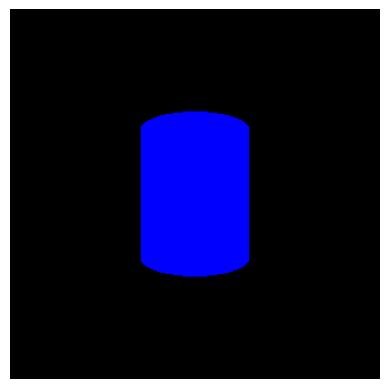

In [22]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [23]:
print(rate)

NameError: name 'rate' is not defined